In [1]:
### Given dictionary of changes, analyze the changes

In [82]:
import databaseOps, fields
import numpy as np
import matplotlib.pyplot as plt
import json
from bs4 import BeautifulSoup, Tag
import copy
from datetime import datetime as dt

In [95]:
import json
from pprint import pprint

with open('changes.json') as data_file:    
    jsonChanges = json.load(data_file)

In [2]:
realChanges = {
  "1545654/000122520817001902/0001225208-17-001902": {
    "dt": {},
    "accNum": "1545654/0001225208-17-001730",
    "head": {},
    "ndt": {
      "1-transaction": {
        "transactionShares": {
          "4A": {
            "value": "<value>615.0000</value><footnoteId id=\"F2\"/>",
            "F2": "The number of shares reflected in the Reporting Person's Form 4 (filed on January 26, 2017) was incorrectly reported. The correct number of shares is reflected in this amendment."
          },
          "4": {
            "value": "<value>678.0000</value>"
          }
        },
        "sharesOwnedFollowingTransaction": {
          "4A": {
            "value": "<value>79801.6695</value>"
          },
          "4": {
            "value": "<value>79738.6695</value>"
          }
        }
      }
    }
  },
  "1253352/000114036117015044/0001140361-17-015044": {
    "dt": {
      "2-transaction": {
        "expirationDate": {
          "4A": {
            "F4": "This option, representing a right to purchase a total of 26,250 shares, was granted on 1/1/2014 and vests over 4 years in equal annual installments commencing on the first anniversary of the grant date.",
            "value": "<footnoteId id=\"F4\"/>"
          },
          "4": {
            "value": "<footnoteId id=\"F3\"/>",
            "F3": "This option, representing a right to purchase a total of 26,250 shares, was granted on 1/1/2014 and vests over 4 years in equal annual installments commencing on the first anniversary of the grant date."
          }
        },
        "exerciseDate": {
          "4A": {
            "F4": "This option, representing a right to purchase a total of 26,250 shares, was granted on 1/1/2014 and vests over 4 years in equal annual installments commencing on the first anniversary of the grant date.",
            "value": "<footnoteId id=\"F4\"/>"
          },
          "4": {
            "value": "<footnoteId id=\"F3\"/>",
            "F3": "This option, representing a right to purchase a total of 26,250 shares, was granted on 1/1/2014 and vests over 4 years in equal annual installments commencing on the first anniversary of the grant date."
          }
        }
      },
      "1-transaction": {
        "expirationDate": {
          "4A": {
            "value": "<footnoteId id=\"F3\"/>",
            "F3": "On January 4, 2016, the reporting person received restricted stock units under Iradimed Corporation's 2014 Equity Incentive Plan. The restricted stock units vest in two equal annual installments beginning on January 4, 2017. Upon vesting, the reporting person will receive a number of shares of common stock equal to the number of restricted stock units that have vested."
          },
          "4": {
            "value": "<footnoteId id=\"F2\"/>",
            "F2": "On January 4, 2016, the reporting person received restricted stock units under Iradimed Corporation's 2014 Equity Incentive Plan. The restricted stock units vest in two equal annual installments beginning on January 4, 2017. Upon vesting, the reporting person will receive a number of shares of common stock equal to the number of restricted stock units that have vested."
          }
        },
        "conversionOrExercisePrice": {
          "4A": {
            "value": "<footnoteId id=\"F2\"/>",
            "F2": "Restricted stock units convert into common stock on a one-for-one basis."
          },
          "4": {
            "F1": "Restricted stock units convert into common stock on a one-for-one basis.",
            "value": "<footnoteId id=\"F1\"/>"
          }
        },
        "exerciseDate": {
          "4A": {
            "value": "<footnoteId id=\"F3\"/>",
            "F3": "On January 4, 2016, the reporting person received restricted stock units under Iradimed Corporation's 2014 Equity Incentive Plan. The restricted stock units vest in two equal annual installments beginning on January 4, 2017. Upon vesting, the reporting person will receive a number of shares of common stock equal to the number of restricted stock units that have vested."
          },
          "4": {
            "value": "<footnoteId id=\"F2\"/>",
            "F2": "On January 4, 2016, the reporting person received restricted stock units under Iradimed Corporation's 2014 Equity Incentive Plan. The restricted stock units vest in two equal annual installments beginning on January 4, 2017. Upon vesting, the reporting person will receive a number of shares of common stock equal to the number of restricted stock units that have vested."
          }
        }
      }
    },
    "accNum": "1253352/0001140361-17-001007",
    "head": {},
    "ndt": {
      "2-transaction": {
        "sharesOwnedFollowingTransaction": {
          "4A": {
            "value": "<value>10960</value>"
          },
          "4": {
            "value": "<value>10340</value>"
          }
        }
      },
      "1-transaction": {
        "transactionShares": {
          "4A": {
            "F1": "This amendment is being filed to remove reference to improperly withheld shares of common stock issued to the reporting person pursuant to the vesting of restricted stock units. Due to an administrative error, upon the vesting of restricted stock units on 1/4/2017, 620 shares of common stock were withheld to satisfy tax withholding obligations as if the reporting person were an employee of the issuer. This error was corrected and the improperly-withheld 620 shares of common stock were issued to the reporting person on 4/3/2017.",
            "value": "<value>1898</value><footnoteId id=\"F1\"/>"
          },
          "4": {
            "value": "<value>1898</value>"
          }
        },
        "transactionPricePerShare": {
          "4A": {
            "value": "<footnoteId id=\"F2\"/>",
            "F2": "Restricted stock units convert into common stock on a one-for-one basis."
          },
          "4": {
            "F1": "Restricted stock units convert into common stock on a one-for-one basis.",
            "value": "<footnoteId id=\"F1\"/>"
          }
        }
      }
    }
  },
  "1444236/000120919117016922/0001209191-17-016922": {
    "dt": {
      "1-transaction": {
        "exerciseDate": {
          "4A": {
            "value": "<value>2018-02-23</value><footnoteId id=\"F3\"/>",
            "F3": "This option vests in four equal annual installments beginning February 23, 2018."
          },
          "4": {
            "value": "<value>2018-02-23</value><footnoteId id=\"F2\"/>",
            "F2": "This option vests in four equal annual installments beginning February 23, 2018."
          }
        }
      }
    },
    "accNum": "1444236/0001209191-17-014948",
    "head": {},
    "ndt": {
      "1-transaction": {
        "sharesOwnedFollowingTransaction": {
          "4A": {
            "value": "<value>17625</value><footnoteId id=\"F2\"/>",
            "F2": "This Amendment is being filed to correct an error in the number of shares of Series A Common Stock beneficially owned after the reported transaction."
          },
          "4": {
            "value": "<value>45833</value>"
          }
        }
      }
    }
  }
}

In [3]:
sampleChanges = {
    "num": {
    "dt": {
      "1-transaction": {
        "securityTitle": {
          "4A": {
            "value": "some title"
          },
          "4": {
            "value": "new title"
          }
        }, "directOrIndirectOwnership": {
          "4A": {
            "value": "<value>D</value>"
          },
          "4": {
            "value": "<value>I</value>"
          }
        },
        "conversionOrExercisePrice": {
          "4A": {
            "value": "<footnoteId id=\"F2\"/>",
            "F2": "Restricted stock units convert into common stock on a one-for-one basis."
          },
          "4": {
            "F1": "Restricted stock units convert into common stock on a one-for-one basis.",
            "value": "<footnoteId id=\"F1\"/>"
          }
        }
      }
    },
    "accNum": "1444236/0001209191-17-014948",
    "head": {},
    "ndt": {
      "1-transaction": {
        "sharesOwnedFollowingTransaction": {
          "4A": {
            "value": "<value>17625</value><footnoteId id=\"F2\"/>",
            "F2": "This Amendment is being filed to correct an error in the number of shares of Series A Common Stock beneficially owned after the reported transaction."
          },
          "4": {
            "value": "<value>45833</value>"
          }
        }, "conversionOrExercisePrice": {
          "4A": {
            "value": "32323"
          },
          "4": {
            "value": "2"
          }
        }
      }
    }
}    
}

In [4]:
numerical = ["transactionShares", "transactionPricePerShare", "sharesOwnedFollowingTransaction", "conversionOrExercisePrice", "underlyingSecurityShares"]

categorical = ["securityTitle", "transactionCode", "equitySwapInvolved", "transactionAcquiredDisposedCode", "directOrIndirectOwnership", "natureOfOwnership", "transactionTimelines", "underlyingSecurityTitlesecurityTitle"]

# categorical data w specified categories
typedCategorical = ["transactionCode", "equitySwapInvolved", "transactionAcquiredDisposedCode", "directOrIndirectOwnership", "transactionTimelines"]

date = ["transactionDate", "exerciseDate", "expirationDate"]

formPortion = ["head", "dt", "ndt"]

In [60]:
beforeVal, afterVal

('', '')

In [102]:
def getNumAnalysis(changedFieldName, beforeVal, afterVal, beforeFoot, afterFoot):
    numAnalysis = dict()
    numAnalysis["fieldName"] = changedFieldName
    numAnalysis["dataType"] = "numerical"
    
    if beforeVal == '':
        beforeVal = 0
        numAnalysis["changeType"] = "insert"
        afterVal = float(afterVal)
    elif afterVal == '':
        afterVal = 0
        numAnalysis["changeType"] = "delete"
        beforeVal = float(beforeVal)
        
    if beforeVal != "" and afterVal != "":
        beforeVal, afterVal = float(beforeVal), float(afterVal)
    
    numAnalysis["amountChanged"] = afterVal - beforeVal
    if afterVal > beforeVal:
        numAnalysis["changeDirection"] = "+" 
    elif afterVal == beforeVal:
        numAnalysis["changeDirection"] = "=" 
        
        if len(afterFoot) > len(beforeFoot):
            numAnalysis["changeType"] = "footnote"
    else:
        numAnalysis["changeDirection"] = "-" 
    numAnalysis["percentChange"] = round(abs(afterVal - beforeVal)/beforeVal*100, 3)
    return numAnalysis

def getCatAnalysis(changedFieldName, beforeVal, afterVal, beforeFoot, afterFoot):
    catAnalysis = dict()
    catAnalysis["dataType"] = "categorical"
    catAnalysis["fieldName"] = changedFieldName
    
    # changed from 1 set category to another
    if changedFieldName in typedCategorical:
        catAnalysis["changeType"] = "update"
        if beforeVal != afterVal:
            catAnalysis["updateVector"] = (beforeVal, afterVal)
        else:
            if len(afterFoot) > len(beforeFoot):
                catAnalysis["changeType"] = "footnote"
    return catAnalysis

def getFootnoteAnalysis(changedFieldName, beforeFoot, afterFoot):
    footnoteAnalysis = dict()
    footnoteAnalysis["dataType"] = "footnote"
    lenChanged = len(afterFoot) - len(beforeFoot)
    footnoteAnalysis["numChanged"] = lenChanged #change in count of footnote
    if lenChanged == 0:
        contentChanged = sum(beforeFoot[i] != afterFoot[i] for i in range(len(beforeFoot)))
        if contentChanged == 0:
            footnoteAnalysis["changeType"] = "noChange"
        else:
            footnoteAnalysis["changeType"] = "footnote"
    return footnoteAnalysis

def getDateAnalysis(changedFieldName, beforeVal, afterVal, beforeFoot, afterFoot):
    dateAnalysis = dict()
    dateAnalysis["dataType"] = "date"
    if beforeVal == "":
        dateAnalysis["changeType"] = "insert"
    if afterVal == "":
        dateAnalysis["changeType"] = "delete"
    if beforeVal != "" and afterVal != "":
        beforeDate = dt.strptime(beforeVal, "%Y-%m-%d")
        afterDate = dt.strptime(afterVal, "%Y-%m-%d")
        if beforeDate == afterDate:
            if len(afterFoot) > len(beforeFoot):
                dateAnalysis["changeType"] = "footnote"
            else:
                dateAnalysis["changeType"] = "noChange"
        elif beforeDate > afterDate:
            dateAnalysis["changeType"] = "madeEarlier" #changed date to earlier
        else:
            dateAnalysis["changeType"] = "madeLater"
    return dateAnalysis


In [103]:
def runAnalysis(fileDic):
    files = copy.deepcopy(fileDic)
    for file in files:
        changeDic = files[file]
        for portion in formPortion:
            for rowKey in list(changeDic[portion].keys()):
                row = changeDic[portion][rowKey]
                
                for changedFieldName in list(row.keys()):
                    footnoteChangeOnly = False

                    if "value" in row[changedFieldName]['4']:
                        beforeVal = row[changedFieldName]['4']['value']
                    else:
                        beforeVal = ""
                    if "value" in row[changedFieldName]['4A']:
                        afterVal = row[changedFieldName]['4A']['value'] 
                    else: 
                        afterVal = ""

                    beforeFoot, afterFoot = None, None
                    if isinstance(beforeVal, str) and ("<value>" in beforeVal or "footnoteId" in beforeVal):
                        beforeSoup = BeautifulSoup(beforeVal)
                        beforeVal = ''.join([str(val.text) for val in beforeSoup.findAll('value')])
                        beforeFoot = [footnote.get('id') for footnote in beforeSoup.findAll('footnoteid')] #soup made it lowercased
                        if beforeVal == '':
                            footnoteChangeOnly = True

                    if isinstance(afterVal, str) and ("<value>" in afterVal or "footnoteId" in afterVal):
                        afterSoup = BeautifulSoup(afterVal)
                        afterVal = ''.join([str(val.text) for val in afterSoup.findAll('value')])
                        afterFoot = [footnote.get('id') for footnote in afterSoup.findAll('footnoteid')]

                        if footnoteChangeOnly:
                            if afterVal != '':
                                footnoteChangeOnly = False

                    if footnoteChangeOnly:
                        beforeFoot = [row[changedFieldName]['4'][fid] for fid in beforeFoot]
                        afterFoot = [row[changedFieldName]['4A'][fid] for fid in afterFoot]
                        row[changedFieldName]["analysis"] = getFootnoteAnalysis(changedFieldName, beforeFoot, afterFoot)
                    else: 
                        if changedFieldName in categorical:
                            row[changedFieldName]["analysis"] = getCatAnalysis(changedFieldName, beforeVal, afterVal, beforeFoot, afterFoot)

                        elif changedFieldName in numerical:
                            #if "footnoteId" not in beforeVal and "footnoteId" not in afterVal:
                            row[changedFieldName]["analysis"] = getNumAnalysis(changedFieldName, beforeVal, afterVal, beforeFoot, afterFoot)
                        elif changedFieldName in date:
                            row[changedFieldName]["analysis"] = getDateAnalysis(changedFieldName, beforeVal, afterVal, beforeFoot, afterFoot)


    print(json.dumps(files, indent=2))
    return files
    
analysis = runAnalysis(jsonChanges)

TypeError: object of type 'NoneType' has no len()

In [70]:
def getAllAnalyses(files, dataType, analysisType=False, analysisSubType=False):
    analyses = {}
    analyses["data"] = []
    if analysisType in categoricalAnalysisType:    
        analyses["metadata"] = {}
        for option in categoricalAnalysisType[analysisType]:
            analyses["metadata"][option] = 0
        
    for file in files:
        changeDic = files[file]
        for portion in formPortion:
            for rowKey in list(changeDic[portion].keys()):
                row = changeDic[portion][rowKey]
                for changedFieldName in list(row.keys()):
                    if "analysis" in row[changedFieldName] and dataType == row[changedFieldName]["analysis"]["dataType"]:
                        if analysisType and analysisType in row[changedFieldName]["analysis"]:
                            data = row[changedFieldName]["analysis"][analysisType]
                            
                            if analysisType in categoricalAnalysisType:
                                analyses["metadata"][data] += 1
                            analyses["data"].append(data)
                        elif not analysisType:
                            analyses["data"].append(row[changedFieldName]["analysis"])
                            
#     if analysisType in numericalAnalysisType:
#         analyses["metadata"] = getNumMetadata(analyses["data"])
    
    return analyses

In [75]:
dataType = ["categorical", "numerical", "footnote", "date"]
categoricalAnalysisType = {
    "changeDirection": ["+", "=", "-"],
    "changeType": ["noChange", "footnote", "madeEarlier", "madeLater", "update"]
}

numericalAnalysisType = ["amountChanged", "percentChange"]

def getNumChanges(files, dataType, analysisType=False, analysisSubType=False):
    analyses = getAllAnalyses(files, dataType, analysisType)
    if analysisType is False:
        print("Number of {} changes: {}".format(dataType, len(analyses["data"])))
    if analysisType is not False:
        print("Number of {} changes in {}: {}".format(dataType, analysisType, len(analyses["data"])))
        if analysisType in categoricalAnalysisType:
            options = categoricalAnalysisType[analysisType]
            for option in options:
                print("Number of {} changes with {} of {}: {}".format(dataType, analysisType, option, analyses["metadata"][option]))
            
az = [getNumChanges(analysis, i) for i in dataType]
getNumChanges(analysis, "numerical", "amountChanged")
getNumChanges(analysis, "numerical", "changeDirection")

Number of categorical changes: 0
Number of numerical changes: 5
Number of footnote changes: 6
Number of date changes: 1
Number of numerical changes in amountChanged: 5
Number of numerical changes in changeDirection: 5
Number of numerical changes with changeDirection of +: 2
Number of numerical changes with changeDirection of =: 1
Number of numerical changes with changeDirection of -: 2


In [68]:
print(getAllAnalyses(analysis, "numerical", "amountChanged"))
print(getAllAnalyses(analysis, "numerical", "changeDirection"))

[63.0, -63.0, -28208.0, 0.0, 620.0]
{'+': 2, '=': 1, '-': 2}


Mean -5517.6
Median 0.0
25% Percentile -63.0
75% Percentile 63.0
Standard deviation 11347.810830287928


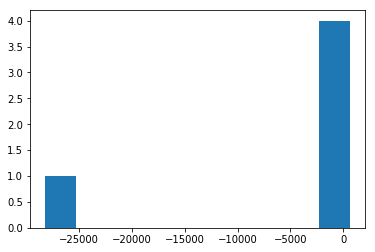

In [94]:
# def getCatStats(dic):

def getNumStats(data, dataType, analysisType): #for distributions
    print("Mean", np.mean(data))
    print("Median", np.median(data))
    print("25% Percentile", np.percentile(data, 25))
    print("75% Percentile", np.percentile(data, 75))
    print("Standard deviation", np.std(data))
    hist, bins = np.histogram(data)
    plt.hist(data, bins)
    plt.title("Distribution of {} changes in {}".format(dataType, analysisType))
    plt.show()

def getNumMetadata(files, dataType, analysisType=False, analysisSubType=False):
    data = getAllAnalyses(files, dataType, analysisType)["data"]
    getStats(data)
    
getNumMetadata(analysis, "numerical", "amountChanged")

In [3]:
import sys
!{sys.executable} -m pip install pandas

    100% |████████████████████████████████| 14.4MB 788kB/s  a 0:00:011
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
